## 1- Código (comentarios y gráficos).

- Divide mi trabajo en 3 partes la primera del código añadiendo comentarios sobre lo que se va haciendo a cada momento posteriomente en la parte dos expreso los resultados obtenidos y como parte final unos gráficos que proporcionan un análisis adicional y complementan la información presentada durante todo el proceso.

### Objetivo del Proyecto:

- El objetivo del proyecto es predecir el estado funcional de los puntos de agua en Tanzania utilizando datos de características y un modelo de machine learning. Este proyecto es parte del desafío "Pump it Up: Data Mining the Water Table" en DrivenData y tarea del Máster Data Science, Big Data & Business Analytics de la UCM.

In [1]:
# Importar librerías 

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score, 
                             precision_score, recall_score, roc_curve, classification_report, 
                             mean_squared_error, r2_score, mean_absolute_percentage_error)
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
import warnings
from scipy.stats.mstats import winsorize
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import statsmodels.api as sm

# Configuración de warnings

warnings.filterwarnings("ignore")

# Configuración de visualización

sns.set(style="whitegrid")

print("Configuración previa completada con éxito")

Configuración previa completada con éxito


In [2]:
# Cargar los datos del conjunto de entrenamiento y el conjunto de pruebas

tr = pd.read_csv('Training_set_values.csv', parse_dates=True)
tr_y = pd.read_csv('Training_set_labels.csv') 
ts = pd.read_csv('Test_set_values.csv', parse_dates=True)

# Mostrar la información básica de los conjuntos de datos

print("Información del conjunto de entrenamiento:")
print(tr.info())
print("\nPrimeras filas del conjunto de entrenamiento:")
print(tr.head())

print("\nInformación del conjunto de etiquetas de entrenamiento:")
print(tr_y.info())
print("\nPrimeras filas del conjunto de etiquetas de entrenamiento:")
print(tr_y.head())

print("\nInformación del conjunto de prueba:")
print(ts.info())
print("\nPrimeras filas del conjunto de prueba:")
print(ts.head())


Información del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_co

In [3]:
# Fusionar el conjunto de entrenamiento con sus etiquetas usando la columna 'id'

dfme = pd.merge(tr, tr_y, on='id', how='inner')

# Verificar la fusión

print("\nInformación del DataFrame fusionado:")
print(dfme.info())
print("\nPrimeras filas del DataFrame fusionado:")
print(dfme.head())




Información del DataFrame fusionado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code   

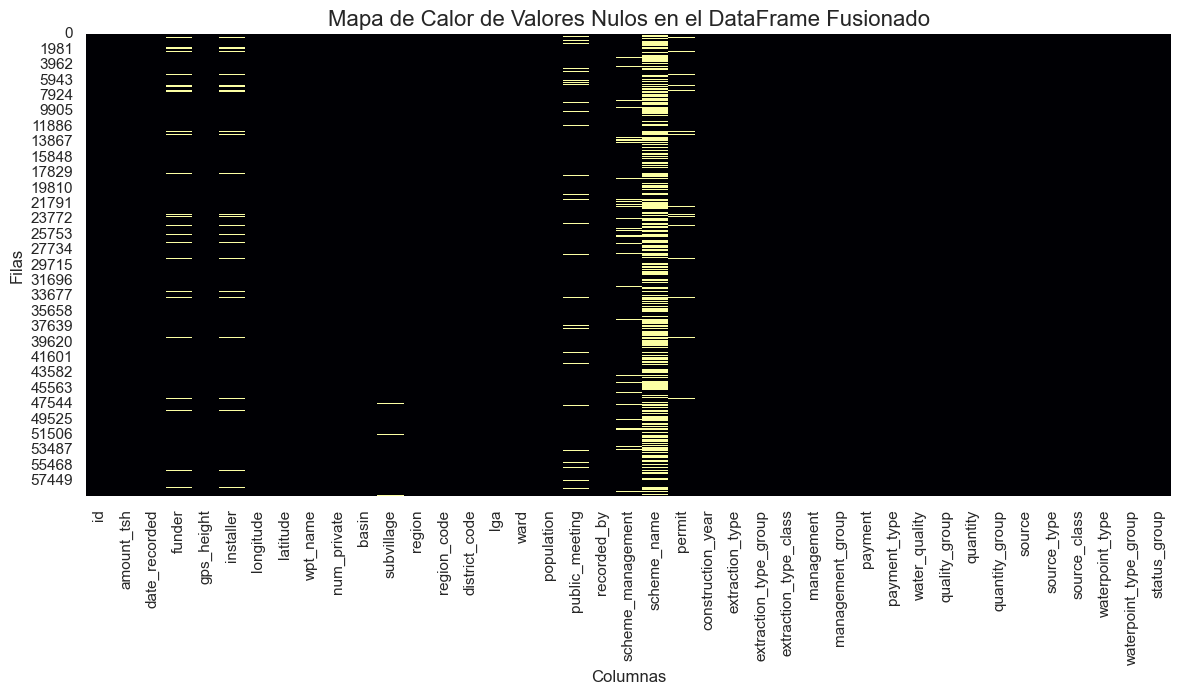

In [4]:
# Visualizar los valores nulos en el DataFrame fusionado usando un mapa de calor

plt.figure(figsize=(14, 6))
sns.heatmap(dfme.isnull(), cbar=False, cmap='inferno')
plt.title('Mapa de Calor de Valores Nulos en el DataFrame Fusionado', fontsize=16)
plt.xlabel('Columnas', fontsize=12)
plt.ylabel('Filas', fontsize=12)
plt.show()

In [5]:
# Verificar la distribución de la variable objetivo 'status_group'
print("Distribución de la variable 'status_group':")
print(dfme['status_group'].value_counts())

# Transformar la variable 'status_group' en una variable numérica
dfme['status_group'] = dfme['status_group'].apply(lambda x: 1 if x == 'functional' 
                                                   else 0 if x == 'non functional'  
                                                   else 2)

# Crear una copia del conjunto de prueba

test = ts.copy()

# Añadir una columna indicadora 'tr' para diferenciar entre entrenamiento y prueba

dfme['tr'] = 1
test['tr'] = 0

# Verificar las modificaciones

print("\nPrimeras filas del DataFrame de entrenamiento modificado:")
print(dfme.head())
print("\nPrimeras filas del DataFrame de prueba modificado:")
print(test.head())


Distribución de la variable 'status_group':
status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

Primeras filas del DataFrame de entrenamiento modificado:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyu

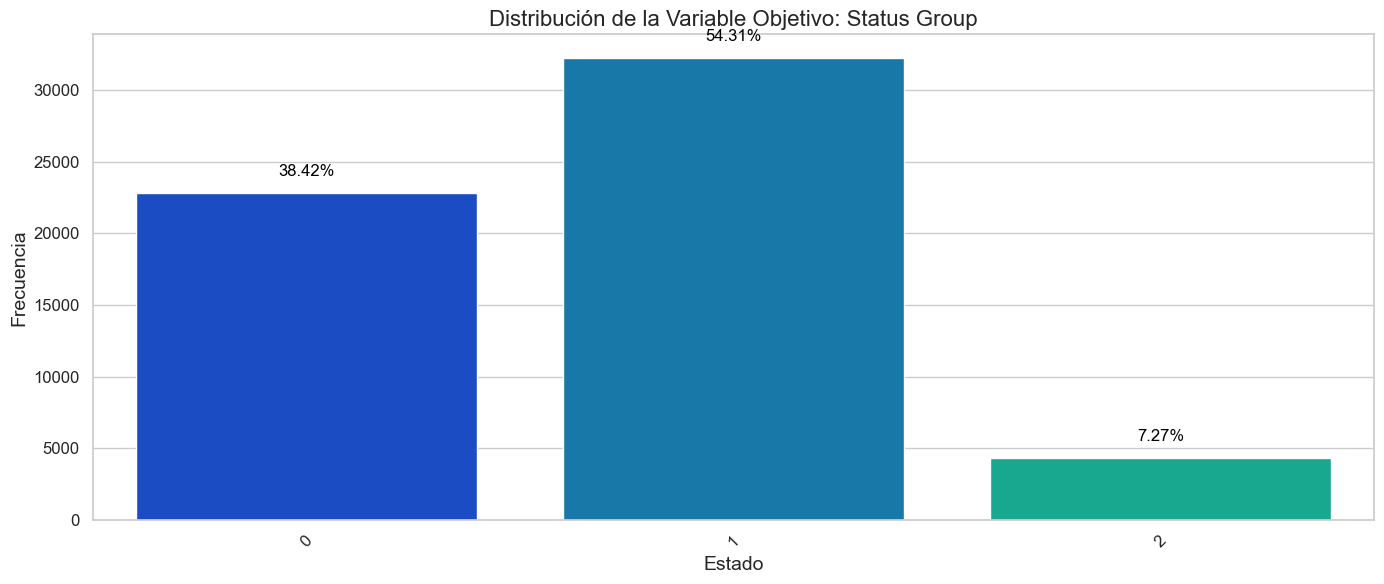

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
ax = sns.countplot(x='status_group', data=dfme, palette='winter')
total = len(dfme)
for p in ax.patches:
    percentage = '{:.2f}%'.format(p.get_height() * 100 / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.02 * total
    ax.annotate(percentage, (x, y), ha='center', fontsize=12, color='black')

ax.set_title('Distribución de la Variable Objetivo: Status Group', fontsize=16)
ax.set_xlabel('Estado', fontsize=14)
ax.set_ylabel('Frecuencia', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

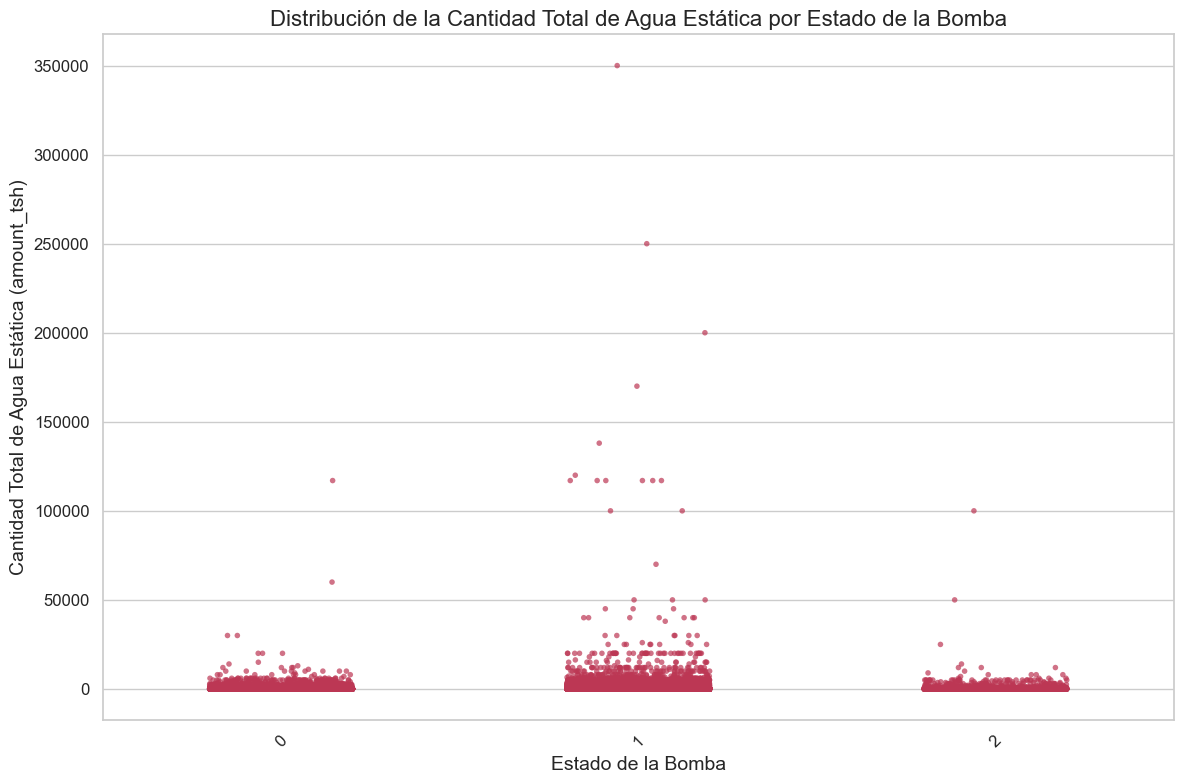

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
color_palette = sns.color_palette("inferno", n_colors=1) 

ax = sns.stripplot(
    x="status_group", 
    y="amount_tsh", 
    data=dfme, 
    jitter=0.2, 
    size=4, 
    palette=color_palette, 
    alpha=0.7
)

plt.title("Distribución de la Cantidad Total de Agua Estática por Estado de la Bomba", fontsize=16)
plt.xlabel("Estado de la Bomba", fontsize=14)
plt.ylabel("Cantidad Total de Agua Estática (amount_tsh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
# Definir listas de columnas por tipo de datos

# Columnas numéricas
lista_numericas = [
    'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 
    'region_code', 'district_code', 'population', 'construction_year'
]

# Columnas categóricas
lista_categoricas = [
    'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 
    'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 
    'extraction_type', 'extraction_type_group', 'extraction_type_class', 
    'management', 'management_group', 'payment', 'payment_type', 'water_quality', 
    'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 
    'source_class', 'waterpoint_type', 'waterpoint_type_group'
]

# Columnas binarias
lista_binarias = ['public_meeting', 'permit']

# Verificar las listas creadas
print("Columnas numéricas:")
print(lista_numericas)
print("\nColumnas categóricas:")
print(lista_categoricas)
print("\nColumnas binarias:")
print(lista_binarias)


Columnas numéricas:
['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

Columnas categóricas:
['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

Columnas binarias:
['public_meeting', 'permit']


In [9]:
# Convertir la columna 'date_recorded' a tipo datetime

dfme['date_recorded'] = pd.to_datetime(dfme['date_recorded'], infer_datetime_format=True)

# Eliminar la columna 'recorded_by' ya que no es útil para el análisis

dfme.drop(columns=['recorded_by'], inplace=True)

# Reemplazar valores cero en 'amount_tsh' por NaN

dfme['amount_tsh'].replace(0, np.nan, inplace=True)

# Reemplazar valores no válidos en 'gps_height' por NaN

dfme['gps_height'] = np.where(dfme['gps_height'] <= 0, np.nan, dfme['gps_height'])

# Reemplazar valores cero en 'latitude' por NaN

dfme['latitude'].replace(0, np.nan, inplace=True)

# Reemplazar valores cero en 'longitude' por NaN

dfme['longitude'].replace(0, np.nan, inplace=True)

# Reemplazar valores cero en 'population' por NaN

dfme['population'].replace(0, np.nan, inplace=True)

# Reemplazar valores cero en 'construction_year' por NaN

dfme['construction_year'].replace(0, np.nan, inplace=True)

# Extraer año, mes y día de 'date_recorded'

dfme['year_recorded'] = dfme['date_recorded'].dt.year
dfme['month_recorded'] = dfme['date_recorded'].dt.month
dfme['day_recorded'] = dfme['date_recorded'].dt.day

# Verificar las modificaciones

print("\nInformación del DataFrame después del preprocesamiento:")
print(dfme.info())
print("\nPrimeras filas del DataFrame después del preprocesamiento:")
print(dfme.head())



Información del DataFrame después del preprocesamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             17761 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55763 non-null  object        
 4   gps_height             37466 non-null  float64       
 5   installer              55745 non-null  object        
 6   longitude              57588 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59398 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  reg

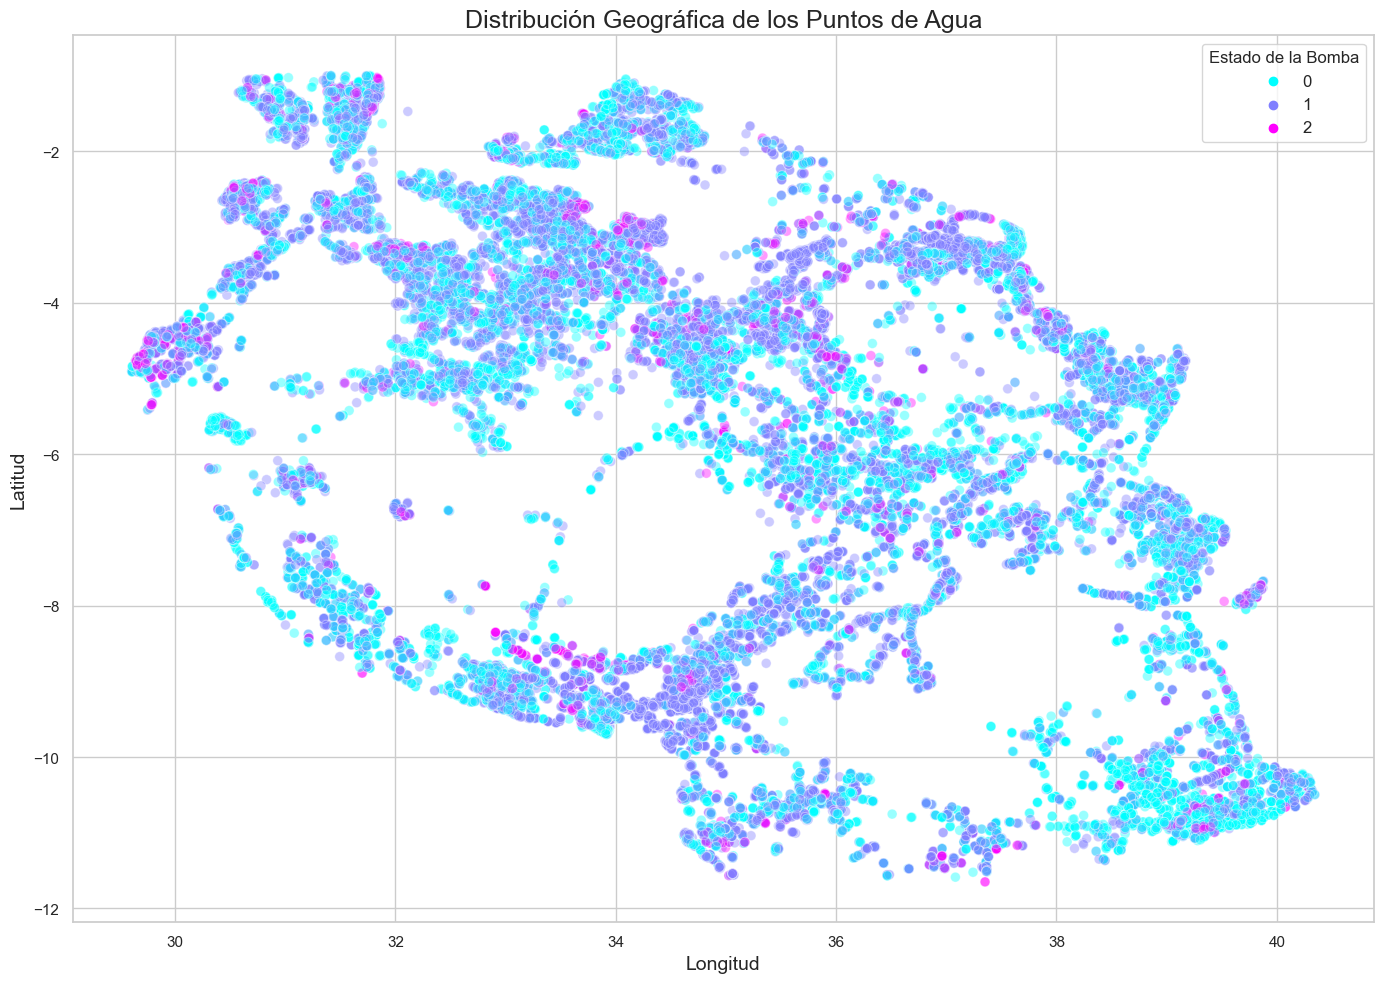

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
ax = sns.scatterplot(
    x="longitude", 
    y="latitude", 
    data=dfme, 
    alpha=0.4, 
    palette='cool',
    hue='status_group', 
    legend='full',
    s=50  
)

plt.title("Distribución Geográfica de los Puntos de Agua", fontsize=18)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Latitud", fontsize=14)
plt.legend(title="Estado de la Bomba", loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
import scipy.stats as stats

# Función para winsorizar utilizando pandas

def winsorize_with_pandas(s, limits):
    """
    Aplica winsorización a una serie pandas.

    Parámetros:
    s (pd.Series): Serie de pandas a procesar.
    limits (tuple): Límites inferior y superior para la winsorización.

    Retorna:
    pd.Series: Serie winsorizada.
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1 - limits[1], interpolation='higher'))

# Función para gestionar outliers

def gestiona_outliers(col, clas='check'):
    """
    Gestiona outliers en una columna de datos.

    Parámetros:
    col (pd.Series): Columna a procesar.
    clas (str): Método para gestionar outliers ('check', 'winsor' o 'miss').

    Retorna:
    Varios tipos según el método seleccionado.
    """
    print(col.name)

    # Condición de asimetría y aplicación de criterio 1 según el caso
    
    if abs(col.skew()) < 1:
        criterio1 = abs((col - col.mean()) / col.std()) > 3
    else:
        criterio1 = abs((col - col.median()) / stats.median_abs_deviation(col)) > 8

    # Calcular primer cuartil     
    
    q1 = col.quantile(0.25)
    
    # Calcular tercer cuartil  
    
    q3 = col.quantile(0.75)
    
    # Calculo de IQR
    
    IQR = q3 - q1
    
    # Calcular criterio 2 (general para cualquier asimetría)
    
    criterio2 = (col < (q1 - 3 * IQR)) | (col > (q3 + 3 * IQR))

    lower = col[criterio1 & criterio2 & (col < q1)].count() / col.dropna().count()
    upper = col[criterio1 & criterio2 & (col > q3)].count() / col.dropna().count()

    # Salida según el tipo deseado
    
    if clas == 'check':
        return lower * 100, upper * 100, (lower + upper) * 100
    elif clas == 'winsor':
        return winsorize_with_pandas(col, (lower, upper))
    elif clas == 'miss':
        print('\nMissing antes: ' + str(col.isna().sum()))
        col.loc[criterio1 & criterio2] = np.nan
        print('Missing después: ' + str(col.isna().sum()) + '\n')
        return col

# Ejemplo de uso
# Verificar outliers en una columna específica
outliers_info = gestiona_outliers(dfme['amount_tsh'], clas='check')
print("Información de outliers (amount_tsh):", outliers_info)


amount_tsh
Información de outliers (amount_tsh): (0.0, 0.0, 0.0)


In [12]:
# Seleccionar las columnas con outliers a gestionar

dfme_out = dfme[['amount_tsh', 'gps_height']]

# Aplicar la función de winsorización a las columnas seleccionadas

dfme_winsor = dfme_out.apply(lambda x: gestiona_outliers(x, clas='winsor'))

# Verificar los primeros valores después de la winsorización

print("Primeros valores ordenados por 'amount_tsh' después de la winsorización:")
print(dfme_winsor.sort_values(by='amount_tsh').head())
print("\nPrimeros valores ordenados por 'gps_height' después de la winsorización:")
print(dfme_winsor.sort_values(by='gps_height').head())

# Eliminar las columnas originales con outliers del DataFrame principal

dfme_in = dfme.drop(columns=['amount_tsh', 'gps_height'])

# Unir los DataFrames procesados y el resto del DataFrame original

dfme_wins = dfme_winsor.join(dfme_in)

# Verificar la información del DataFrame final

print("\nInformación del DataFrame final después de gestionar outliers:")
print(dfme_wins.info())

# Contar los valores nulos en el DataFrame final

print("\nConteo de valores nulos en el DataFrame final:")
print(dfme_wins.isnull().sum())

# Calcular el porcentaje de valores nulos en cada columna del DataFrame final

missing_percentage = dfme_wins.apply(lambda x: x.isna().sum() / dfme_wins.shape[0] * 100)
print("\nPorcentaje de valores nulos en cada columna del DataFrame final:")
print(missing_percentage)


amount_tsh
gps_height
Primeros valores ordenados por 'amount_tsh' después de la winsorización:
       amount_tsh  gps_height
15519        0.20       953.0
4086         0.20       952.0
11140        0.20       852.0
49378        0.25       685.0
3652         1.00         NaN

Primeros valores ordenados por 'gps_height' después de la winsorización:
       amount_tsh  gps_height
46120        20.0         1.0
46365         NaN         1.0
42583        30.0         1.0
23075         NaN         1.0
31393        50.0         1.0

Información del DataFrame final después de gestionar outliers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             17761 non-null  float64       
 1   gps_height             37466 non-null  float64       
 2   id                     59400 non-null  int64         
 3 

In [13]:
# Separar columnas categóricas importantes

imp_cat = dfme_wins[['funder', 'installer', 'subvillage', 'scheme_management', 'scheme_name']]

# Separar columnas continuas importantes

imp_cont = dfme_wins[['amount_tsh', 'gps_height', 'longitude', 'population', 'construction_year']]

# Eliminar las columnas categóricas y continuas seleccionadas del DataFrame principal

dfme_wins.drop(columns=[
    'funder', 'installer', 'subvillage', 'scheme_management', 'scheme_name', 
    'amount_tsh', 'gps_height', 'longitude', 'population', 'construction_year'
], inplace=True)

# Verificar el DataFrame después de la eliminación de columnas
print("\nInformación del DataFrame después de eliminar columnas categóricas y continuas importantes:")
print(dfme_wins.info())



Información del DataFrame después de eliminar columnas categóricas y continuas importantes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   date_recorded          59400 non-null  datetime64[ns]
 2   latitude               59400 non-null  float64       
 3   wpt_name               59398 non-null  object        
 4   num_private            59400 non-null  int64         
 5   basin                  59400 non-null  object        
 6   region                 59400 non-null  object        
 7   region_code            59400 non-null  int64         
 8   district_code          59400 non-null  int64         
 9   lga                    59400 non-null  object        
 10  ward                   59400 non-null  object        
 11  public_meeting         560

In [14]:
import sklearn.impute as skl_imp
from sklearn.experimental import enable_iterative_imputer
import feature_engine.imputation as fe_imp

# Imputación por Moda: Solo para columnas categóricas nominales

imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)

# Imputación por Mediana: Solo para columnas numéricas

imputer_median = fe_imp.MeanMedianImputer(imputation_method='median')

# Imputación KNN: Solo para columnas numéricas

imputer_knn = skl_imp.KNNImputer(n_neighbors=3)

# Aplicar la imputación por mediana a las columnas continuas

median_imputed = imputer_median.fit_transform(imp_cont)

# Convertir a DataFrame y mostrar las primeras filas

median_imputed = pd.DataFrame(median_imputed, columns=imp_cont.columns)
print("\nPrimeras filas después de la imputación por mediana:")
print(median_imputed.head())

# Aplicar la imputación por moda a las columnas categóricas

moda_imputed = pd.DataFrame(imputer_moda.fit_transform(imp_cat), columns=imp_cat.columns)
print("\nPrimeras filas después de la imputación por moda:")
print(moda_imputed.head())

# Concatenar las columnas imputadas con el DataFrame principal

dfme_median_moda = pd.concat([dfme_wins, median_imputed, moda_imputed], axis=1)

# Crear una copia del DataFrame final imputado

dfme1_copy = dfme_median_moda.copy()

# Verificar el porcentaje de valores nulos en cada columna del DataFrame final imputado

missing_percentage = dfme_median_moda.apply(lambda x: x.isna().sum() / dfme_median_moda.shape[0] * 100)
print("\nPorcentaje de valores nulos en cada columna del DataFrame final imputado:")
print(missing_percentage)



Primeras filas después de la imputación por mediana:
   amount_tsh  gps_height  longitude  population  construction_year
0      6000.0      1390.0  34.938093       109.0             1999.0
1       250.0      1399.0  34.698766       280.0             2010.0
2        25.0       686.0  37.460664       250.0             2009.0
3       250.0       263.0  38.486161        58.0             1986.0
4       250.0      1194.0  31.130847       150.0             2000.0

Primeras filas después de la imputación por moda:
         funder     installer  subvillage scheme_management  \
0         Roman         Roman    Mnyusi B               VWC   
1       Grumeti       GRUMETI     Nyamara             Other   
2  Lottery Club  World vision     Majengo               VWC   
3        Unicef        UNICEF  Mahakamani               VWC   
4   Action In A       Artisan  Kyanyamisa               VWC   

                   scheme_name  
0                        Roman  
1                            K  
2  Nyumba

In [15]:
# Reemplazo de valores categóricos por valores numéricos en la columna 'quantity'

dfme_median_moda['quantity'].replace(
    ('enough', 'insufficient', 'dry', 'seasonal', 'unknown'),
    (1, 2, 3, 4, 5),
    inplace=True
)

# Reemplazo de valores categóricos por valores numéricos en la columna 'quantity_group'

dfme_median_moda['quantity_group'].replace(
    ('enough', 'insufficient', 'dry', 'seasonal', 'unknown'),
    (1, 2, 3, 4, 5),
    inplace=True
)

# Reemplazo de valores categóricos por valores numéricos en la columna 'source_class'

dfme_median_moda['source_class'].replace(
    ('groundwater', 'surface', 'unknown'),
    (1, 2, 3),
    inplace=True
)

# Reemplazo de valores categóricos por valores numéricos en la columna 'payment'

dfme_median_moda['payment'].replace(
    ('never pay', 'pay per bucket', 'pay monthly', 'unknown', 'pay when scheme fails', 'pay annually', 'other'),
    (1, 2, 3, 4, 5, 6, 7),
    inplace=True
)

# Reemplazo de valores categóricos por valores numéricos en la columna 'payment_type'

dfme_median_moda['payment_type'].replace(
    ('never pay', 'per bucket', 'monthly', 'unknown', 'on failure', 'annually', 'other'),
    (1, 2, 3, 4, 5, 6, 7),
    inplace=True
)

# Verificar los cambios realizados

print("\nPrimeras filas del DataFrame después de la sustitución de valores categóricos por numéricos:")
print(dfme_median_moda.head())



Primeras filas del DataFrame después de la sustitución de valores categóricos por numéricos:
      id date_recorded   latitude              wpt_name  num_private  \
0  69572    2011-03-14  -9.856322                  none            0   
1   8776    2013-03-06  -2.147466              Zahanati            0   
2  34310    2013-02-25  -3.821329           Kwa Mahundi            0   
3  67743    2013-01-28 -11.155298  Zahanati Ya Nanyumbu            0   
4  19728    2011-07-13  -1.825359               Shuleni            0   

                     basin   region  region_code  district_code        lga  \
0               Lake Nyasa   Iringa           11              5     Ludewa   
1            Lake Victoria     Mara           20              2  Serengeti   
2                  Pangani  Manyara           21              4  Simanjiro   
3  Ruvuma / Southern Coast   Mtwara           90             63   Nanyumbu   
4            Lake Victoria   Kagera           18              1    Karagwe   

    

In [16]:
from sklearn.preprocessing import LabelEncoder

# Inicializar el codificador de etiquetas

lecod = LabelEncoder()

# Lista de columnas categóricas a codificar

list_lecod = [
    'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 
    'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 
    'extraction_type_class', 'management', 'management_group', 'water_quality', 
    'quality_group', 'source', 'source_type', 'waterpoint_type', 'waterpoint_type_group'
]

# Aplicar LabelEncoder a cada columna categórica en la lista

for column in list_lecod:
    dfme_median_moda[column] = lecod.fit_transform(dfme_median_moda[column])

# Verificar los cambios realizados

print("\nPrimeras filas del DataFrame después de la codificación de etiquetas:")
print(dfme_median_moda.head())



Primeras filas del DataFrame después de la codificación de etiquetas:
      id date_recorded   latitude  wpt_name  num_private  basin  region  \
0  69572    2011-03-14  -9.856322     37398            0      1       3   
1   8776    2013-03-06  -2.147466     37194            0      4       9   
2  34310    2013-02-25  -3.821329     14572            0      5       8   
3  67743    2013-01-28 -11.155298     37284            0      7      12   
4  19728    2011-07-13  -1.825359     35528            0      4       4   

   region_code  district_code  lga  ward public_meeting permit  \
0           11              5   51  1426           True  False   
1           20              2  103  1576            NaN   True   
2           21              4  108  1624           True   True   
3           90             63   87  1571           True   True   
4           18              1   26  1687           True   True   

   extraction_type  extraction_type_group  extraction_type_class  management  \
0

In [17]:
# Mostrar las primeras filas del DataFrame después de la imputación y codificación

print("\nPrimeras filas del DataFrame después de la imputación y codificación:")
print(dfme_median_moda.head(5))

# Separar el DataFrame en conjuntos de entrenamiento y prueba según la columna 'tr'

dfme_tr1 = dfme_median_moda[dfme_median_moda['tr'] == 1]
dfme_ts1 = dfme_median_moda[dfme_median_moda['tr'] == 0]

# Calcular la matriz de correlación

corr = abs(dfme_median_moda.corr())

# Mostrar la correlación de todas las características con la variable objetivo 'status_group'

correlation_with_target = corr[['status_group']].sort_values(by='status_group', ascending=False)

# Estilizar el DataFrame de correlaciones para mejor visualización

styled_corr = correlation_with_target.style.background_gradient(cmap='inferno')

print("\nCorrelación de características con 'status_group':")
display(styled_corr)



Primeras filas del DataFrame después de la imputación y codificación:
      id date_recorded   latitude  wpt_name  num_private  basin  region  \
0  69572    2011-03-14  -9.856322     37398            0      1       3   
1   8776    2013-03-06  -2.147466     37194            0      4       9   
2  34310    2013-02-25  -3.821329     14572            0      5       8   
3  67743    2013-01-28 -11.155298     37284            0      7      12   
4  19728    2011-07-13  -1.825359     35528            0      4       4   

   region_code  district_code  lga  ward public_meeting permit  \
0           11              5   51  1426           True  False   
1           20              2  103  1576            NaN   True   
2           21              4  108  1624           True   True   
3           90             63   87  1571           True   True   
4           18              1   26  1687           True   True   

   extraction_type  extraction_type_group  extraction_type_class  management  \
0

,status_group
status_group,1.000000
quantity_group,0.222332
quantity,0.222332
waterpoint_type_group,0.196292
extraction_type_class,0.195627
waterpoint_type,0.193195
construction_year,0.164142
quality_group,0.150430
extraction_type_group,0.134387
extraction_type,0.124155


In [18]:
# Separar la columna 'id' y la variable objetivo 'status_group'

tr_id = dfme_tr1['id']
tr_varObj = dfme_tr1['status_group']

# Eliminar columnas no necesarias del conjunto de entrenamiento

dfme_tr1.drop(columns=['id', 'date_recorded', 'tr'], inplace=True)

# Crear una copia del conjunto de entrenamiento

tr_copy = dfme_tr1.copy()

# Eliminar la columna 'status_group' del conjunto de entrenamiento

dfme_tr1.drop(columns=['status_group'], inplace=True)

# Dividir el conjunto de datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    dfme_tr1, tr_varObj, test_size=0.2, random_state=42, stratify=tr_varObj
)

# Entrenar el modelo Random Forest

model_r = RandomForestClassifier(random_state=42)
model_r.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba

y_pred = model_r.predict(X_test)

# Evaluación del modelo

print('Matriz de Confusión:')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy:')
print(accuracy_score(y_test, y_pred))

print('\nPrecision:')
print(precision_score(y_test, y_pred, average='weighted'))

print('\nRecall:')
print(recall_score(y_test, y_pred, average='weighted'))

print('\nF1 Score:')
print(f1_score(y_test, y_pred, average='weighted'))

print('\nReporte de Clasificación:')
print(classification_report(y_test, y_pred))


Matriz de Confusión:
[[3653  838   74]
 [ 558 5715  179]
 [ 142  423  298]]

Accuracy:
0.8136363636363636

Precision:
0.806680862858939

Recall:
0.8136363636363636

F1 Score:
0.8077085399014787

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      4565
           1       0.82      0.89      0.85      6452
           2       0.54      0.35      0.42       863

    accuracy                           0.81     11880
   macro avg       0.73      0.68      0.70     11880
weighted avg       0.81      0.81      0.81     11880



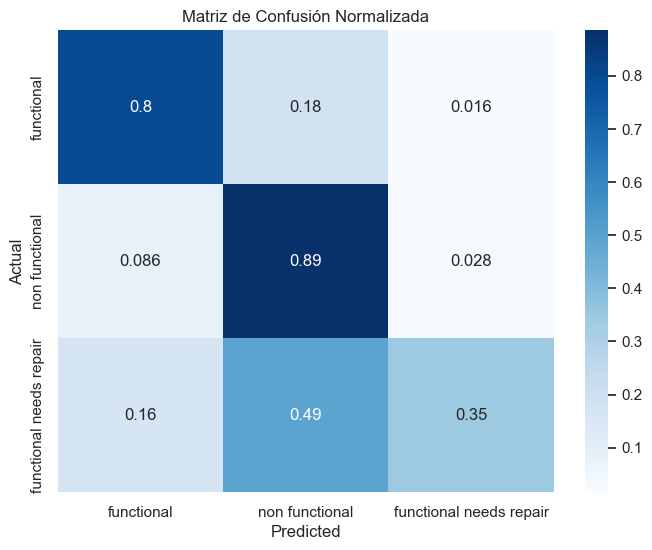

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico: Matriz de Confusión Normalizada

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=['functional', 'non functional', 'functional needs repair'], yticklabels=['functional', 'non functional', 'functional needs repair'])
plt.title('Matriz de Confusión Normalizada')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

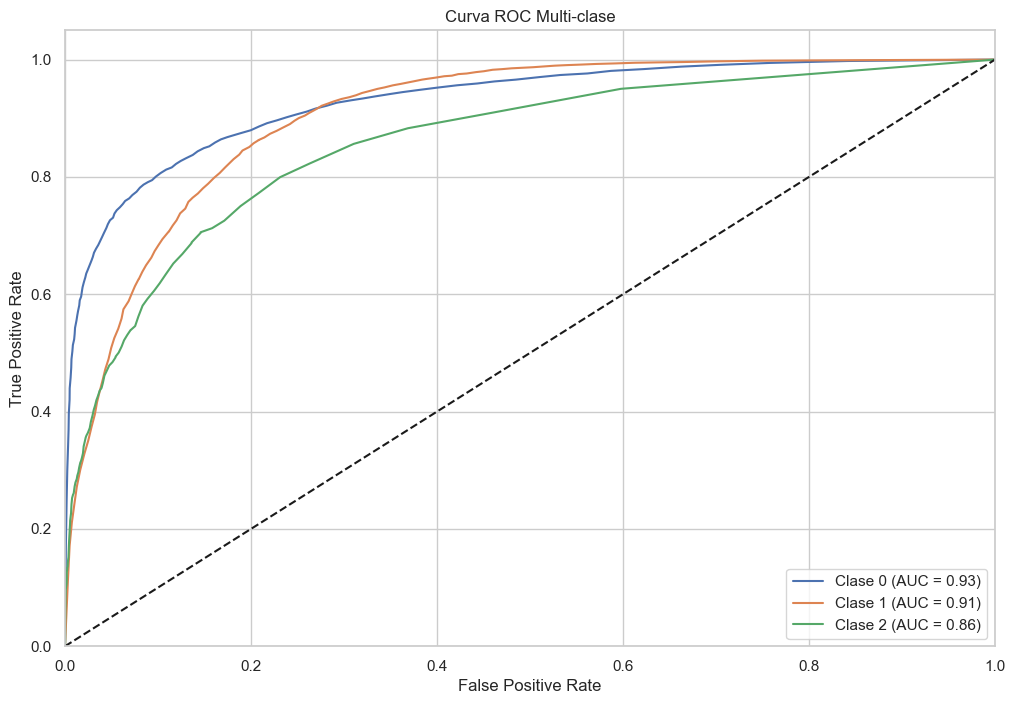

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Gráfico: Curva ROC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_pred_prob = model_r.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_prob[:, i])

plt.figure(figsize=(12, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Multi-clase')
plt.legend(loc='lower right')
plt.show()

In [21]:
from sklearn.preprocessing import LabelEncoder
import sklearn.impute as skl_imp
import feature_engine.imputation as fe_imp

def preprocess(var):
    # Clasificar las columnas por tipo de variable
    
    lista_num = [
        'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 
        'region_code', 'district_code', 'population', 'construction_year'
    ]
    lista_cat = [
        'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 
        'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type', 
        'extraction_type_group', 'extraction_type_class', 'management', 
        'management_group', 'payment', 'payment_type', 'water_quality', 
        'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 
        'source_class', 'waterpoint_type', 'waterpoint_type_group'
    ]
    lista_bin = ['public_meeting', 'permit']
    
    # Cambiar tipo de dato de 'date_recorded' a datetime
    
    var['date_recorded'] = pd.to_datetime(var['date_recorded'], infer_datetime_format=True)

    # Eliminar la columna 'recorded_by' si existe
    
    if 'recorded_by' in var.columns:
        var.drop(columns=['recorded_by'], inplace=True)
    
    # Reemplazar valores incorrectos con NaN
    
    var['amount_tsh'].replace(0, np.nan, inplace=True)
    var['gps_height'] = np.where(var['gps_height'] <= 0, np.nan, var['gps_height'])
    var['latitude'].replace(0, np.nan, inplace=True)
    var['longitude'].replace(0, np.nan, inplace=True)
    var['population'].replace(0, np.nan, inplace=True)
    var['construction_year'].replace(0, np.nan, inplace=True)
    
    # Crear variables adicionales a partir de 'date_recorded'
    
    var['year_recorded'] = var['date_recorded'].dt.year
    var['month_recorded'] = var['date_recorded'].dt.month
    var['day_recorded'] = var['date_recorded'].dt.day
    
    # Convertir variables binarias a 0 y 1
    
    for i in lista_bin:
        var[i] = var[i].apply(lambda x: 1 if x else 0)
        
    # Tratar outliers en las columnas seleccionadas
    
    dfme_out = var[['amount_tsh', 'gps_height']]
    dfmewinsor = dfme_out.apply(lambda x: gestiona_outliers(x, clas='winsor'))
    
    # Juntar las columnas tratadas con el resto del DataFrame
    
    dmefin = var.drop(columns=['amount_tsh', 'gps_height'])
    dfmewins = dfmewinsor.join(dmefin)
    
    # Imputaciones de columnas categóricas y continuas
    
    imp_cat = dfmewins[['funder', 'installer', 'subvillage', 'scheme_management', 'scheme_name']]
    imp_cont = dfmewins[['amount_tsh', 'gps_height', 'longitude', 'population', 'construction_year']]
    
    dfmewins.drop(columns=[
        'funder', 'installer', 'subvillage', 'scheme_management', 
        'scheme_name', 'amount_tsh', 'gps_height', 'longitude', 
        'population', 'construction_year'
    ], inplace=True)
    
    # Imputación por moda (categóricas) y mediana (numéricas)
    
    imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)
    imputer_median = fe_imp.MeanMedianImputer(imputation_method='median')

    median_imp = imputer_median.fit_transform(imp_cont)
    moda_imp = pd.DataFrame(imputer_moda.fit_transform(imp_cat), columns=imp_cat.columns)
    
    # Concatenar columnas imputadas con el DataFrame principal
    
    dfme_med_mod = pd.concat([dfmewins, median_imp, moda_imp], axis=1)
    
    # Transformar valores categóricos a numéricos
    
    dfme_med_mod['quantity'].replace(('enough', 'insufficient', 'dry', 'seasonal', 'unknown'), (1, 2, 3, 4, 5), inplace=True)
    dfme_med_mod['quantity_group'].replace(('enough', 'insufficient', 'dry', 'seasonal', 'unknown'), (1, 2, 3, 4, 5), inplace=True)
    dfme_med_mod['source_class'].replace(('groundwater', 'surface', 'unknown'), (1, 2, 3), inplace=True)
    dfme_med_mod['payment'].replace(('never pay', 'pay per bucket', 'pay monthly', 'unknown', 'pay when scheme fails', 'pay annually', 'other'), (1, 2, 3, 4, 5, 6, 7), inplace=True)
    dfme_med_mod['payment_type'].replace(('never pay', 'per bucket', 'monthly', 'unknown', 'on failure', 'annually', 'other'), (1, 2, 3, 4, 5, 6, 7), inplace=True)

    # Codificación de etiquetas para variables categóricas
    
    lecod = LabelEncoder()
    lista_lecod = [
        'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 
        'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type', 
        'extraction_type_group', 'extraction_type_class', 'management', 
        'management_group', 'water_quality', 'quality_group', 'source', 
        'source_type', 'waterpoint_type', 'waterpoint_type_group'
    ]
    
    for col in lista_lecod:
        dfme_med_mod[col] = lecod.fit_transform(dfme_med_mod[col].astype(str))
        
    # Eliminar la columna 'date_recorded' ya que ya se han creado variables adicionales
    
    dfme_med_mod.drop(columns=['date_recorded'], inplace=True)

    return dfme_med_mod

# Preprocesar el conjunto de prueba

dfme_test = preprocess(test)

# Guardar el ID del conjunto de prueba

ts_id = dfme_test['id']

# Eliminar la columna 'id' y 'tr' del conjunto de prueba si existen

dfme_test.drop(columns=['id'], inplace=True)
if 'tr' in dfme_test.columns:
    dfme_test.drop(columns=['tr'], inplace=True)

# Realizar predicciones con el modelo entrenado

y_prd = model_r.predict(dfme_test)

# Convertir las predicciones en un DataFrame

y_predicted = pd.DataFrame(y_prd, columns=['status_group'])

# Concatenar el ID del conjunto de prueba con las predicciones

final = pd.concat([ts_id, y_predicted], axis=1)

# Mapear las predicciones a sus valores categóricos originales

final['status_group'] = final['status_group'].apply(lambda x: 'functional' if x == 1
                                                    else 'non functional' if x == 0
                                                    else 'functional needs repair')

# Guardar el resultado final en un archivo CSV

final.to_csv('Submission_tonigm.csv', index=False)

print("Archivo de envío para DrivenData 'Submission_tonigm.csv' creado con éxito.")


amount_tsh
gps_height
Archivo de envío para DrivenData 'Submission_tonigm.csv' creado con éxito.


# 2- Resumen del Código y Resultados.


### Pasos del Proceso:

- Siempre comenzando con la importación de Librerías requeridas para el análisis de datos, visualización, preprocesamiento, modelado y evaluación.

- Inmediatametne despues con la carga de Datos:

- Los datos se cargaron desde archivos CSV (Training_set_values.csv, Training_set_labels.csv, Test_set_values.csv).

### Y ya entrando en materia con el Preprocesamiento de Datos:

- Conversión de Fechas: Se convirtió la columna date_recorded a tipo datetime.

- Manejo de Valores Nulos y Outliers: Se reemplazaron valores cero por NaN en columnas específicas y se aplicó winsorización para tratar los outliers.

- Creación de Características: Se crearon nuevas características a partir de la fecha (year_recorded, month_recorded, day_recorded).

- Transformación de Variables Binarias: Se convirtieron las variables binarias a valores 0 y 1.

- Imputación de Valores Faltantes: Se aplicaron métodos de imputación (mediana para numéricas y moda para categóricas).

- Transformación de Variables Categóricas:

- Se utilizaron LabelEncoder y reemplazos directos para transformar las variables categóricas a numéricas.

- División de Datos:Se separaron los datos en conjuntos de entrenamiento y prueba, eliminando las columnas no necesarias.

### Entrenamiento del Modelo (RandomForestClassifier):

- Se entrenó un modelo RandomForestClassifier utilizando los datos de entrenamiento.

- Evaluación del Modelo: Se evaluó el modelo utilizando la matriz de confusión, accuracy, precision, recall, F1 score y el reporte de clasificación.

### Parte final de Predicción y Exportación:

- Se preprocesaron los datos de prueba de manera similar a los datos de entrenamiento.

- Se realizaron predicciones utilizando el modelo entrenado.

- Se mapearon las predicciones a sus valores categóricos originales.

- Se exportaron los resultados a un archivo CSV (Submission_tonigm.csv) para su envío.

### Resultados:

- Score Final: El modelo alcanzó un score de :
# 0.8081 
##### "Pump it Up: Data Mining the Water Table" en DrivenData.

El resultado obtenido en esta tarea para Drivendata es de:


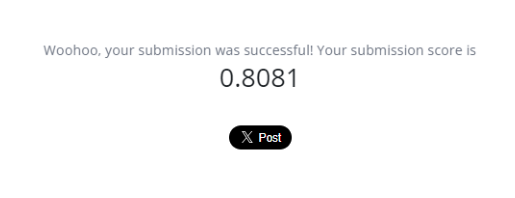

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print('El resultado obtenido en esta tarea para Drivendata es de:')
img = mpimg.imread(r'C:\Users\PC\last_score_1405.png')

plt.imshow(img)
plt.axis('off') 
plt.show()

El mejor resultado obtenido en mi participación Drivendata es de:


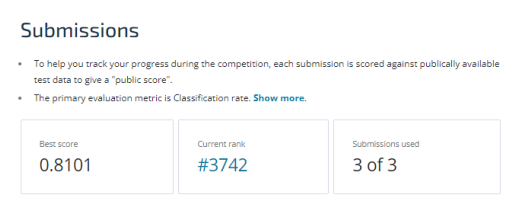

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print('El mejor resultado obtenido en mi participación Drivendata es de:')
img = mpimg.imread(r'C:\Users\PC\endscore_antoniogonzalez_tonigm.png')

plt.imshow(img)
plt.axis('off') 
plt.show()

## Como muestra la imagen, experimenté con varios modelos y métodos. A continuación, presento un breve resumen y las conclusiones alcanzadas : 

El ranking de intentos durante todo mi tiempo es:


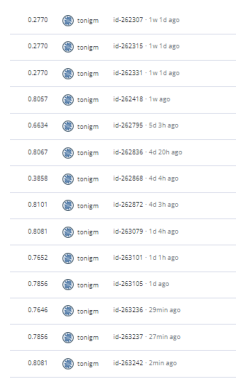

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print('El ranking de intentos durante todo mi tiempo es:')
img = mpimg.imread(r'C:\Users\PC\tonigm_intentos.png')

plt.imshow(img)
plt.axis('off') 
plt.show()

- Resumen de Participación en "Pump it Up: Data Mining the Water Table"
- Usuario: tonigm
- Rango Actual: #3742

Desde el primer día de participación en la competencia "Pump it Up: Data Mining the Water Table" en DrivenData, hace más de dos semanas, he realizado múltiples intentos para optimizar el rendimiento de mi modelo. A continuación, se detalla el progreso y los resultados obtenidos en cada uno de mis envíos:

- Hace más de dos semanas, mis primeros intentos se vieron obstaculizados por errores en los encabezados del archivo CSV y problemas con los IDs en las presentaciones. Los primeros envíos (id-260922 e id-260924) fueron rechazados debido a que los encabezados no coincidían con el formato requerido ("id,status_group"). Estos errores me llevaron a ajustar el formato de mis archivos antes de realizar más presentaciones.

- Posteriormente, varios envíos adicionales (id-262221 a id-262230) resultaron en errores debido a IDs incorrectos para la presentación. Este problema persistió en varios intentos consecutivos, donde recibí mensajes de error indicando que los IDs no eran correctos.

- Alrededor de hace una semana, empecé a ver mejoras en mis resultados. Sin embargo, algunos envíos todavía tenían problemas, como la cantidad incorrecta de filas en los archivos presentados. Por ejemplo, el envío id-262293 fue rechazado porque tenía 59400 filas en lugar de las 14850 requeridas. Ajustando nuevamente mi enfoque, algunos intentos posteriores (id-262294) fallaron por una fila de menos, mostrando que los datos presentados no estaban completamente alineados con las expectativas del sistema.

- Finalmente, después de todo el proceso anterior con varios ajustes y pruebas, logré enviar presentaciones exitosas. Mis envíos id-262306, id-262307 e id-262315 obtuvieron un score de 0.2770. Con más refinamientos, el envío id-262331 mejoró significativamente con un score de 0.8057, seguido por id-262418 con un score de 0.6634.

- En la ultima semana, con el envío id-262795, logré un score de 0.8067. Aunque el envío id-262836 resultó en un score inferior de 0.3858, rápidamente volví a mejorar con los envíos siguientes. Tres días atrás, obtuve mi mejor resultado hasta el momento: el envío id-262868 alcanzó un score de 0.8101, demostrando que los ajustes realizados en mi modelo estaban dando resultados positivos. Un segundo mejor score de 0.8081 fue alcanzado poco después con el envío id-262872 que tras realizar unos cambios me impidieron volver al mejor por poco.

- En los últimos días, he continuado afinando mi modelo probando otros que detallo posteriormente. Mis envíos más recientes, id-263079 e id-263101, obtuvieron scores de 0.7652 y 0.7856, respectivamente.

## Conclusión

- A lo largo de este tiempo, he trabajado profundamente para mejorar el rendimiento de mi modelo, probando una amplia variedad de enfoques y ajustando numerosos parámetros. A pesar de los desafíos iniciales con los formatos de archivo y los IDs, el Random Forest demostró ser para mi el modelo más eficaz, alcanzando un score máximo de 0.8101. Este resultado destaca el progreso significativo logrado en la competencia, posicionándome en el puesto #3742 dado el dia que terminé este trabajo.


## Resumen de los resultados obtenidos con cada modelo y su precisión máxima:

1. - Random Forest
Accuracy: 0.8081

2. - XGBoost
Accuracy: 0.7766

3. - CatBoost
Accuracy: 0.7979

4. - LightGBM
Accuracy: 0.8023

5. - Voting Classifier
Combinación de Modelos: Random Forest, Logistic Regression, SVM, XGBoost
Accuracy: 0.7860


## Resumen Final

El modelo de Random Forest obtuvo el mayor puntaje de precisión con un accuracy de 0.8081. Le siguen LightGBM con 0.8023 y CatBoost con 0.7979. XGBoost y Voting Classifier también tuvieron un desempeño notable, aunque ligeramente inferior.

Este análisis me ayudo a decidir qué modelo utilizar en función del equilibrio entre precisión y recall para cada clase, así como la precisión general del modelo. A pesar de haber explorado y evaluado una variedad de modelos diferentes, el Random Forest demostró ser el más eficaz y logró obtener la mejor puntuación en la competición de DrivenData.

###### Nota: Los otros modelos fueron entrenados en diferentes notebooks con el objetivo de encontrar el mejor score.

# 3-  Análisis Visual Adicional.

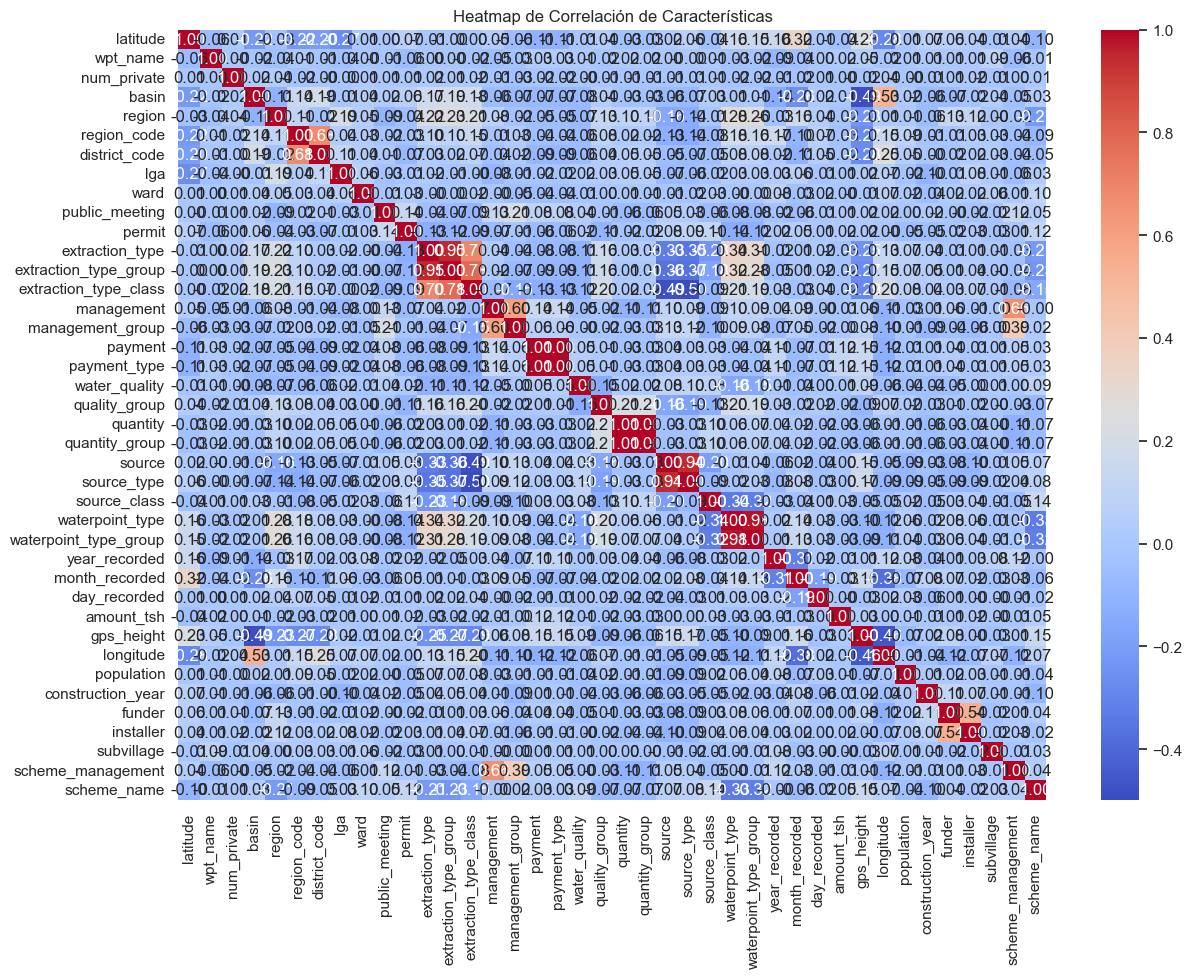

In [24]:
# Heatmap de Correlación me parecio bastante interesante y curioso.

plt.figure(figsize=(14, 10))
correlation_matrix = dfme_tr1.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlación de Características')
plt.show()

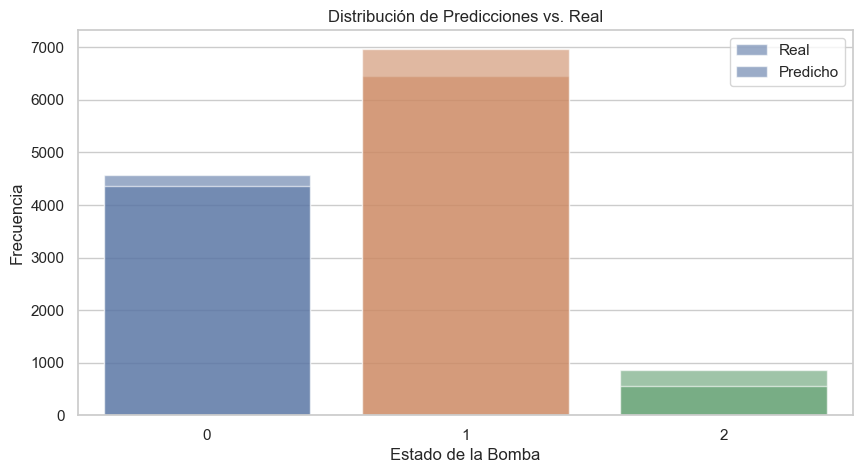

In [25]:
# Grafico Distribucion de Precicciones vs Real

plt.figure(figsize=(10, 5))
sns.countplot(x=y_test, label='Real', alpha=0.6)
sns.countplot(x=y_pred, label='Predicho', alpha=0.6)
plt.title('Distribución de Predicciones vs. Real')
plt.xlabel('Estado de la Bomba')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

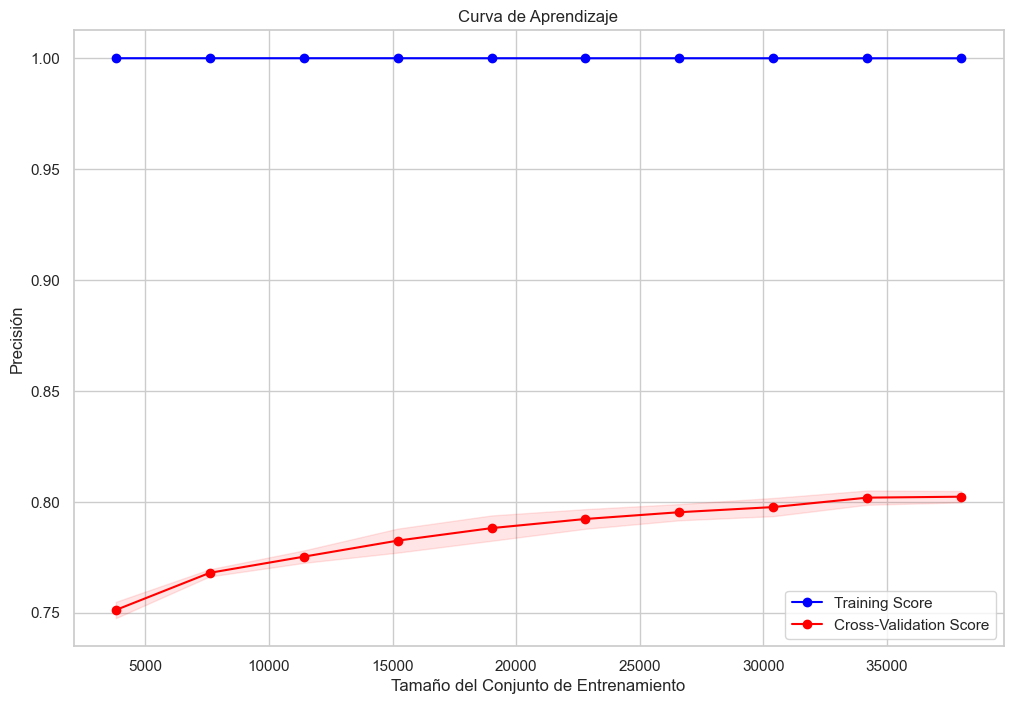

In [26]:
from sklearn.model_selection import learning_curve

# Grafico Curva de Aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model_r, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Cross-Validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.title('Curva de Aprendizaje')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Precisión')
plt.legend(loc='best')
plt.show()

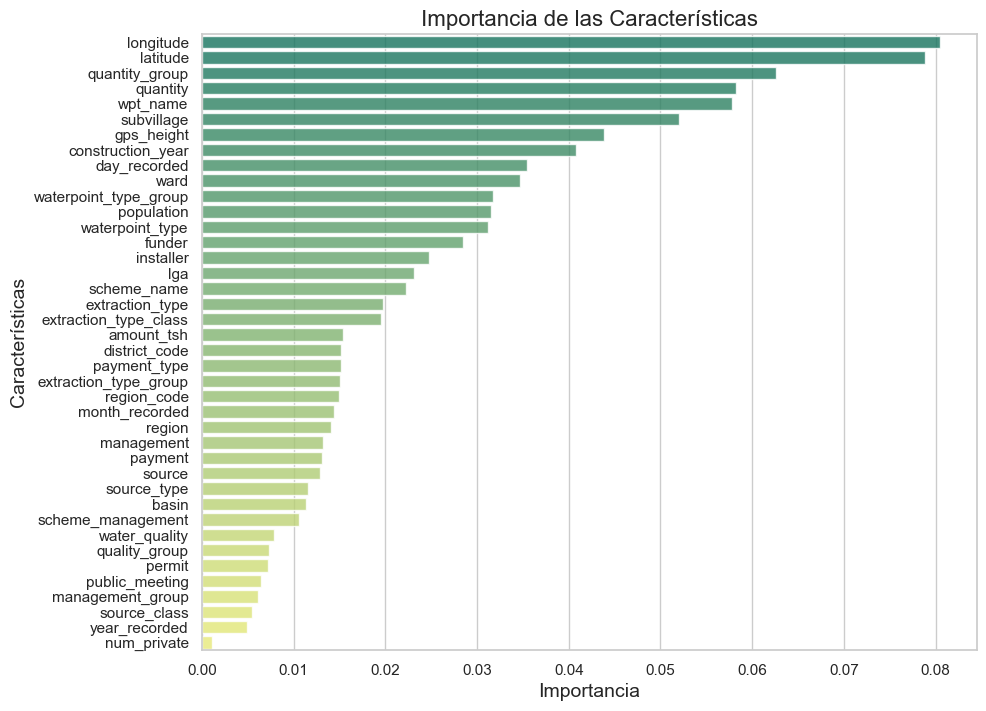

In [27]:
# Finalmente un grafico que muestra la importacion de la Caracteristicas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.DataFrame(model_r.feature_importances_, index=X_train.columns, columns=["Importance"])

feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Importance', y=feat_importances.index, data=feat_importances, palette='summer', alpha=0.8)
ax.set_title('Importancia de las Características', fontsize=16)
ax.set_xlabel('Importancia', fontsize=14)
ax.set_ylabel('Características', fontsize=14)
plt.show()